In [2]:
import scipy as sc
from scipy.integrate import odeint, solve_bvp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pyccl as ccl
from mpl_toolkits import mplot3d
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import corner

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [3]:
# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1
# note: k is unitless (ie. k is actually k/H0)

def xi_SH(a, cosmo1, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    if alpha_C == 0:
        return 1
    else:
        Omega_m = Omega_c + Omega_b
        Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
        return (k**2)*a**2/((k**2)*a**2 - 6*alpha_C)

    
def xi(a, cosmo1, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_g = Omega_r - alpha_C
    if alpha_C == 0:
        return (k**2)*a**2/((k**2 + 3*(Easquared(a,cosmo1)/a)**2)*a**2)
    else:
        Omega_m = Omega_c + Omega_b
        Omega_lambda = 1 - Omega_m - Omega_g - Omega_k - alpha_C
        return (k**2)*a**2/((k**2 + 3*(Easquared(a,cosmo1)/a)**2)*a**2 - 6*alpha_C)


# Define Ea^2 = H/H0 a^2 (a suqared to avoid singularity)
def Easquared(a,cosmo1):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*a + (Omega_r + alpha_C) + Omega_k*a**(2) + Omega_lambda*a**(4))

# Second order ODE for D_+(a)
def solverGrowth(y,a, cosmo1, k):
    Omega_c = cosmo1[0]
    Omega_b = cosmo1[1]
    Omega_m = Omega_c + Omega_b
    Easq_val = Easquared(a, cosmo1)
    D , a3EdDda = y
    return np.array([(a3EdDda / (Easq_val*a)), 3*Omega_m*D*xi(a, cosmo1, k)/(2*Easq_val)])

# Second order ODE for D_+(a)
def solverGrowth_SH(y,a, cosmo1, k):
    Omega_c = cosmo1[0]
    Omega_b = cosmo1[1]
    Omega_m = Omega_c + Omega_b
    Easq_val = Easquared(a, cosmo1)
    D , a3EdDda = y
    return np.array([(a3EdDda / (Easq_val*a)), 3*Omega_m*D*xi_SH(a, cosmo1, k)/(2*Easq_val)])

# Function to find the index at which an array is the closest to a certain value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [4]:
k_val = 5
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 3e-6 ]
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

(0.0001, 1)

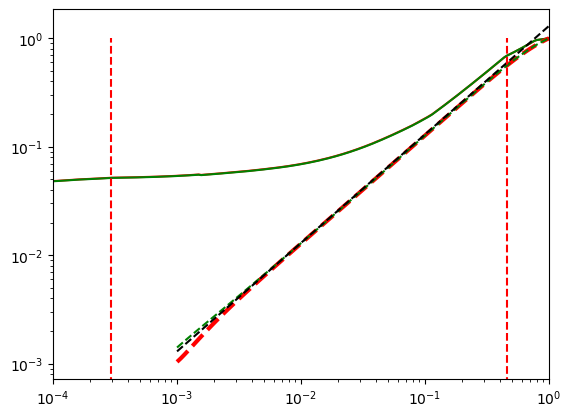

In [18]:
a_val = np.logspace(-10,0,500)

D_val = odeint(solverGrowth, np.array([a_val[0], a_val[0]*Easquared(a_val[0],cosmo)]), a_val, args=(cosmo,k_val), mxstep=int(1e4))
plt.plot(a_val,D_val.T[0]/D_val.T[0][-1], color="r")

D_val = odeint(solverGrowth, np.array([a_val[0], a_val[0]*Easquared(a_val[0],cosmo_LCDM_array)]), a_val, args=(cosmo_LCDM_array,k_val), mxstep=int(1e4))
plt.plot(a_val,D_val.T[0]/D_val.T[0][-1], color="g")

a_val = np.logspace(-3,0,100)
#D_val = odeint(solverGrowth, np.array([a_val[0], a_val[0]*Easquared(a_val[0],cosmo_LCDM_array)]), a_val, args=(cosmo_LCDM_array,k_val), mxstep=int(1e4))
#plt.plot(a_val,D_val.T[0]/D_val.T[0][-1], color="g")
D_val = odeint(solverGrowth_SH, np.array([a_val[0], a_val[0]*Easquared(a_val[0],cosmo)]), a_val, args=(cosmo,k_val), mxstep=int(1e4))
plt.plot(a_val,D_val.T[0]/D_val.T[0][-1], "r--", linewidth=3)
D_val = odeint(solverGrowth_SH, np.array([a_val[0], a_val[0]*Easquared(a_val[0],cosmo_LCDM_array)]), a_val, args=(cosmo_LCDM_array,k_val), mxstep=int(1e4))
plt.plot(a_val,D_val.T[0]/D_val.T[0][-1], "g--")

plt.plot(a_val,a_val*1.3, "k--")
plt.plot([cosmo[3]/(cosmo[0]+cosmo[1]),cosmo[3]/(cosmo[0]+cosmo[1])], [0,1], "r--",label="matter domination")
plt.plot([(cosmo[0]+cosmo[1])/(1-cosmo[0]-cosmo[1]-cosmo[3]-cosmo[4]),(cosmo[0]+cosmo[1])/(1-cosmo[0]-cosmo[1]-cosmo[3]-cosmo[4])], [0,1], "r--")

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-4,1)

In [217]:
k_val = np.logspace(-5,2,300)
N_eff = 3.5
Omg_r = (1 + (7/8) * (4/11)**(4/3)*(N_eff - 3.046))*2.47282e-5*1e4/67**2
Omg_r_LCDM = 2.47282e-5*1e4/67**2

cosmo_val = [cosmo[0] , cosmo[1], cosmo[2] ,cosmo[3] , Omg_r-Omg_r_LCDM]
cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.86,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2],
                               Omega_g=2.47282e-5*1e4/67**2,
                               Neff = N_eff,
                               m_nu_type = "single",
                               m_nu = 0.6000000E-01
                              )
# Define LCDM cosmology
cosmo_val_LCDM = [cosmo[0] , cosmo[1], cosmo[2] ,cosmo[3] , 0]
# find soln 4DEGB
soln = np.zeros((len(k_val), len(a_val)))
soln_LCDM = np.zeros((len(k_val), len(a_val)))
for i in range(len(k_val)):
    soln[i] = odeint(solverGrowth, np.array([a_val[0], a_val[0]*Easquared(a_val[0],cosmo_val)]), a_val, args=(cosmo_val,k_val[i]*(3e5/100)/cosmoCCL["h"]), mxstep=int(1e4)).T[0]
    soln[i] = soln[i]/soln[i][-1]
    # find soln LCDM
    soln_LCDM[i] = odeint(solverGrowth, np.array([a_val[0], a_val[0]*Easquared(a_val[0],cosmo_val_LCDM)]), a_val, args=(cosmo_val_LCDM,k_val[i]*(3e5/100)/cosmoCCL["h"]), mxstep=int(1e4)).T[0]
    soln_LCDM[i] = soln_LCDM[i]/soln_LCDM[i][-1]

print(np.sqrt(sc.integrate.trapz(k_val**2 *(soln_LCDM[:,find_nearest(a_val,1/1101)]/soln[:,find_nearest(a_val,1/1101)])**2*ccl.power.linear_matter_power(cosmoCCL, k_val, 1)*\
                           (3*sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"], derivative=False)/(k_val*8/cosmoCCL["h"]))**2,\
                           x=k_val)/(2*np.pi**2)))

for i in range(len(k_val)):
    soln[i] = odeint(solverGrowth_SH, np.array([a_val[0], a_val[0]*Easquared(a_val[0],cosmo_val)]), a_val, args=(cosmo_val,k_val[i]*(3e5/100)/cosmoCCL["h"]), mxstep=int(1e4)).T[0]
    soln[i] = soln[i]/soln[i][-1]
    # find soln LCDM
    soln_LCDM[i] = odeint(solverGrowth_SH, np.array([a_val[0], a_val[0]*Easquared(a_val[0],cosmo_val_LCDM)]), a_val, args=(cosmo_val_LCDM,k_val[i]*(3e5/100)/cosmoCCL["h"]), mxstep=int(1e4)).T[0]
    soln_LCDM[i] = soln_LCDM[i]/soln_LCDM[i][-1]

print(np.sqrt(sc.integrate.trapz(k_val**2 *(soln_LCDM[:,find_nearest(a_val,1/1101)]/soln[:,find_nearest(a_val,1/1101)])**2*ccl.power.linear_matter_power(cosmoCCL, k_val, 1)*\
                           (3*sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"], derivative=False)/(k_val*8/cosmoCCL["h"]))**2,\
                           x=k_val)/(2*np.pi**2)))

0.8552290710922906
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1303749374776D+00   r2 =  0.5591565751065D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1303749374776D+00   r2 =  0.5591565751065D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1303749374776D+00   r2 =  0.1118313150213D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1303749374776D+00   r2 =  0.1118313150213D-16
 lsoda--  warning